In [1]:
import h5py
from pathlib import Path
import numba
from helper_functions import *
from sktime.classification.feature_based import FreshPRINCE
from sklearn.model_selection import cross_val_score, StratifiedKFold
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import warnings
import joblib
import matplotlib.pyplot as plt
from sktime.classification.kernel_based import RocketClassifier
warnings.filterwarnings('ignore')

/Users/sinanbasaran/Documents/GitHub/demo-LCDB1.1/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [6]:
### hyperparameter
OPENML_ID = {0: '3', 1: '6', 2: '11', 3: '12', 4: '13', 5: '14', 6: '15', 7: '16', 8: '18', 9: '21', 10: '22', 11: '23', 12: '24', 13: '26', 14: '28', 15: '29', 16: '30', 17: '31', 18: '32', 19: '36', 20: '37', 21: '38', 22: '44', 23: '46', 24: '50', 25: '54', 26: '55', 27: '57', 28: '60', 29: '61', 30: '151', 31: '179', 32: '180', 33: '181', 34: '182', 35: '184', 36: '185', 37: '188', 38: '201', 39: '273', 40: '293', 41: '299', 42: '300', 43: '307', 44: '336', 45: '346', 46: '351', 47: '354', 48: '357', 49: '380', 50: '389', 51: '390', 52: '391', 53: '392', 54: '393', 55: '395', 56: '396', 57: '398', 58: '399', 59: '401', 60: '446', 61: '458', 62: '469', 63: '554', 64: '679', 65: '715', 66: '718', 67: '720', 68: '722', 69: '723', 70: '727', 71: '728', 72: '734', 73: '735', 74: '737', 75: '740', 76: '741', 77: '743', 78: '751', 79: '752', 80: '761', 81: '772', 82: '797', 83: '799', 84: '803', 85: '806', 86: '807', 87: '813', 88: '816', 89: '819', 90: '821', 91: '822', 92: '823', 93: '833', 94: '837', 95: '843', 96: '845', 97: '846', 98: '847', 99: '849', 100: '866', 101: '871', 102: '881', 103: '897', 104: '901', 105: '903', 106: '904', 107: '910', 108: '912', 109: '913', 110: '914', 111: '917', 112: '923', 113: '930', 114: '934', 115: '953', 116: '958', 117: '959', 118: '962', 119: '966', 120: '971', 121: '976', 122: '977', 123: '978', 124: '979', 125: '980', 126: '991', 127: '993', 128: '995', 129: '1000', 130: '1002', 131: '1018', 132: '1019', 133: '1020', 134: '1021', 135: '1036', 136: '1040', 137: '1041', 138: '1042', 139: '1049', 140: '1050', 141: '1053', 142: '1056', 143: '1063', 144: '1067', 145: '1068', 146: '1069', 147: '1083', 148: '1084', 149: '1085', 150: '1086', 151: '1087', 152: '1088', 153: '1116', 154: '1119', 155: '1120', 156: '1128', 157: '1130', 158: '1134', 159: '1138', 160: '1139', 161: '1142', 162: '1146', 163: '1161', 164: '1166', 165: '1216', 166: '1233', 167: '1235', 168: '1236', 169: '1441', 170: '1448', 171: '1450', 172: '1457', 173: '1461', 174: '1462', 175: '1464', 176: '1465', 177: '1468', 178: '1475', 179: '1477', 180: '1478', 181: '1479', 182: '1480', 183: '1483', 184: '1485', 185: '1486', 186: '1487', 187: '1488', 188: '1489', 189: '1494', 190: '1497', 191: '1499', 192: '1501', 193: '1503', 194: '1509', 195: '1510', 196: '1515', 197: '1566', 198: '1567', 199: '1575', 200: '1590', 201: '1592', 202: '1597', 203: '4134', 204: '4135', 205: '4137', 206: '4534', 207: '4538', 208: '4541', 209: '6332', 210: '23381', 211: '23512', 212: '23517', 213: '40498', 214: '40499', 215: '40664', 216: '40668', 217: '40670', 218: '40672', 219: '40677', 220: '40685', 221: '40687', 222: '40701', 223: '40713', 224: '40900', 225: '40910', 226: '40923', 227: '40927', 228: '40966', 229: '40971', 230: '40975', 231: '40978', 232: '40979', 233: '40981', 234: '40982', 235: '40983', 236: '40984', 237: '40994', 238: '40996', 239: '41027', 240: '41142', 241: '41143', 242: '41144', 243: '41145', 244: '41146', 245: '41150', 246: '41156', 247: '41157', 248: '41158', 249: '41159', 250: '41161', 251: '41163', 252: '41164', 253: '41165', 254: '41166', 255: '41167', 256: '41168', 257: '41169', 258: '41228', 259: '41972', 260: '42734', 261: '42742', 262: '42769', 263: '42809', 264: '42810'}
LEARNER_ZOO = {0: 'SVC_linear', 1: 'SVC_poly', 2: 'SVC_rbf', 3: 'SVC_sigmoid', 4: 'Decision Tree', 5: 'ExtraTree', 6: 'LogisticRegression', 7: 'PassiveAggressive', 8: 'Perceptron', 9: 'RidgeClassifier', 10: 'SGDClassifier', 11: 'MLP', 12: 'LDA', 13: 'QDA', 14: 'BernoulliNB', 15: 'MultinomialNB', 16: 'ComplementNB', 17: 'GaussianNB', 18: 'KNN', 19: 'NearestCentroid', 20: 'ens.ExtraTrees', 21: 'ens.RandomForest', 22: 'ens.GradientBoosting', 23: 'DummyClassifier'}
ANCHOR_SIZE = np.ceil(16 * 2 ** ((np.arange(137)) / 8)).astype(int)

### load data: validation accuracy
lc_data = h5py.File(Path.cwd() / 'dataset/LCDB11_ACC_265_noFS_raw_compress.hdf5', 'r')['accuracy'][...][:,:,:,:,:,1]

mean_valid_lc_nofs =np.nanmean(lc_data, axis=(2, 3))

In [7]:
all_data = mean_valid_lc_nofs.reshape(-1, mean_valid_lc_nofs.shape[-1])
labels = np.tile(np.arange(24), 265)

all_data.shape, labels.shape

((6360, 137), (6360,))

In [8]:
group_definitions = {
    0: ['Perceptron', 'PassiveAggressive', 'SGDClassifier', 'SVC_linear'],
    1: ['Decision Tree', 'ExtraTree', 'MLP'],
    2: ['SVC_poly', 'SVC_rbf', 'ens.ExtraTrees', 'ens.RandomForest', 'KNN'],
    3: ['MultinomialNB', 'ComplementNB', 'NearestCentroid', 'GaussianNB', 'BernoulliNB'],
    4: ['RidgeClassifier', 'LogisticRegression', 'LDA'],
    5: ['DummyClassifier', 'SVC_sigmoid', 'QDA', 'ens.GradientBoosting'],
}

In [10]:
lengths = list(range(10, 140, 10))

accuracies = {}
stds = {}
num_curves = {}

for min_len in lengths:
    print(f"\n=== Processing min_len = {min_len} ===")
    
    filtered_curves_mean, _, filtered_group_labels_mean = filter_by_group_definitions(
        all_data, labels, group_definitions, LEARNER_ZOO
    )

    # clean curves by length
    clean_curves_mean, clean_labels_mean = clean_curves(filtered_curves_mean, filtered_group_labels_mean, min_len)
    
    print(f"Number of curves: {len(clean_curves_mean)}")
    num_curves[min_len] = len(clean_curves_mean)
    
    # print label distribution
    unique_labels, counts = np.unique(clean_labels_mean, return_counts=True)
    print("Label distribution:")
    for label, count in zip(unique_labels, counts):
        print(f"  Label {label}: {count} occurrences")

    # skip if too few samples
    if len(clean_curves_mean) < 10:
        print("  Skipped: Too few samples after cleaning.")
        continue

    # pad sequences
    max_len = max(len(seq) for seq in clean_curves_mean)
    padded_curves = pad_sequences(clean_curves_mean, maxlen=max_len, dtype='float32', padding='post', truncating='post')

    # reshape: (n_instances, n_channels (1), n_timepoints)
    X = padded_curves[:, np.newaxis, :]
    y = clean_labels_mean

    try:
        clf = RocketClassifier(rocket_transform='minirocket', random_state=42)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(clf, X, y, cv=cv)
        
        accuracies[min_len] = scores.mean()
        stds[min_len] = scores.std()
        
        joblib.dump(scores, f'scores/experiment-different-lengths/minirocket/minirocket_{min_len}_scores.joblib')
        joblib.dump(clf, f'trained_models/experiment-different-lengths/minirocket/minirocket_{min_len}_clf.joblib')
        
        print(f"  Cross-validated accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

    except Exception as e:
        print(f"  Error during processing: {e}")


=== Processing min_len = 10 ===
Number of curves: 6176
Label distribution:
  Label 0: 1056 occurrences
  Label 1: 792 occurrences
  Label 2: 1320 occurrences
  Label 3: 1160 occurrences
  Label 4: 792 occurrences
  Label 5: 1056 occurrences


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


  Cross-validated accuracy: 0.5837 ± 0.0135

=== Processing min_len = 20 ===
Number of curves: 6094
Label distribution:
  Label 0: 1044 occurrences
  Label 1: 783 occurrences
  Label 2: 1305 occurrences
  Label 3: 1139 occurrences
  Label 4: 783 occurrences
  Label 5: 1040 occurrences
  Cross-validated accuracy: 0.5786 ± 0.0087

=== Processing min_len = 30 ===
Number of curves: 5803
Label distribution:
  Label 0: 996 occurrences
  Label 1: 747 occurrences
  Label 2: 1245 occurrences
  Label 3: 1081 occurrences
  Label 4: 747 occurrences
  Label 5: 987 occurrences
  Cross-validated accuracy: 0.5926 ± 0.0091

=== Processing min_len = 40 ===
Number of curves: 5511
Label distribution:
  Label 0: 948 occurrences
  Label 1: 711 occurrences
  Label 2: 1185 occurrences
  Label 3: 1019 occurrences
  Label 4: 711 occurrences
  Label 5: 937 occurrences
  Cross-validated accuracy: 0.6021 ± 0.0159

=== Processing min_len = 50 ===
Number of curves: 4217
Label distribution:
  Label 0: 724 occurrences

In [12]:
lengths = list(range(10, 140, 10))

accuracies = {}
stds = {}
num_curves = {}

for min_len in lengths:
    print(f"\n=== Processing min_len = {min_len} ===")
    
    filtered_curves_mean, _, filtered_group_labels_mean = filter_by_group_definitions(
        all_data, labels, group_definitions, LEARNER_ZOO
    )

    # clean curves by length
    clean_curves_mean, clean_labels_mean = clean_curves(filtered_curves_mean, filtered_group_labels_mean, min_len)
    
    print(f"Number of curves: {len(clean_curves_mean)}")
    num_curves[min_len] = len(clean_curves_mean)
    
    # print label distribution
    unique_labels, counts = np.unique(clean_labels_mean, return_counts=True)
    print("Label distribution:")
    for label, count in zip(unique_labels, counts):
        print(f"  Label {label}: {count} occurrences")

    # skip if too few samples
    if len(clean_curves_mean) < 10:
        print("  Skipped: Too few samples after cleaning.")
        continue

    # pad sequences
    max_len = max(len(seq) for seq in clean_curves_mean)
    padded_curves = pad_sequences(clean_curves_mean, maxlen=max_len, dtype='float32', padding='post', truncating='post')

    # reshape: (n_instances, n_channels (1), n_timepoints)
    X = padded_curves[:, np.newaxis, :]
    y = clean_labels_mean

    try:
        clf = FreshPRINCE(n_jobs=-1, random_state=42)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(clf, X, y, cv=cv)
        
        accuracies[min_len] = scores.mean()
        stds[min_len] = scores.std()
        
        joblib.dump(scores, f'scores/experiment-different-lengths/freshprince/freshprince_{min_len}_scores.joblib')
        joblib.dump(clf, f'trained_models/experiment-different-lengths/freshprince/freshprince_{min_len}_clf.joblib')
        
        print(f"  Cross-validated accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

    except Exception as e:
        print(f"  Error during processing: {e}")


=== Processing min_len = 10 ===
Number of curves: 6176
Label distribution:
  Label 0: 1056 occurrences
  Label 1: 792 occurrences
  Label 2: 1320 occurrences
  Label 3: 1160 occurrences
  Label 4: 792 occurrences
  Label 5: 1056 occurrences
  Cross-validated accuracy: 0.6154 ± 0.0043

=== Processing min_len = 20 ===
Number of curves: 6094
Label distribution:
  Label 0: 1044 occurrences
  Label 1: 783 occurrences
  Label 2: 1305 occurrences
  Label 3: 1139 occurrences
  Label 4: 783 occurrences
  Label 5: 1040 occurrences
  Cross-validated accuracy: 0.6140 ± 0.0204

=== Processing min_len = 30 ===
Number of curves: 5803
Label distribution:
  Label 0: 996 occurrences
  Label 1: 747 occurrences
  Label 2: 1245 occurrences
  Label 3: 1081 occurrences
  Label 4: 747 occurrences
  Label 5: 987 occurrences
  Cross-validated accuracy: 0.6295 ± 0.0113

=== Processing min_len = 40 ===
Number of curves: 5511
Label distribution:
  Label 0: 948 occurrences
  Label 1: 711 occurrences
  Label 2: 118

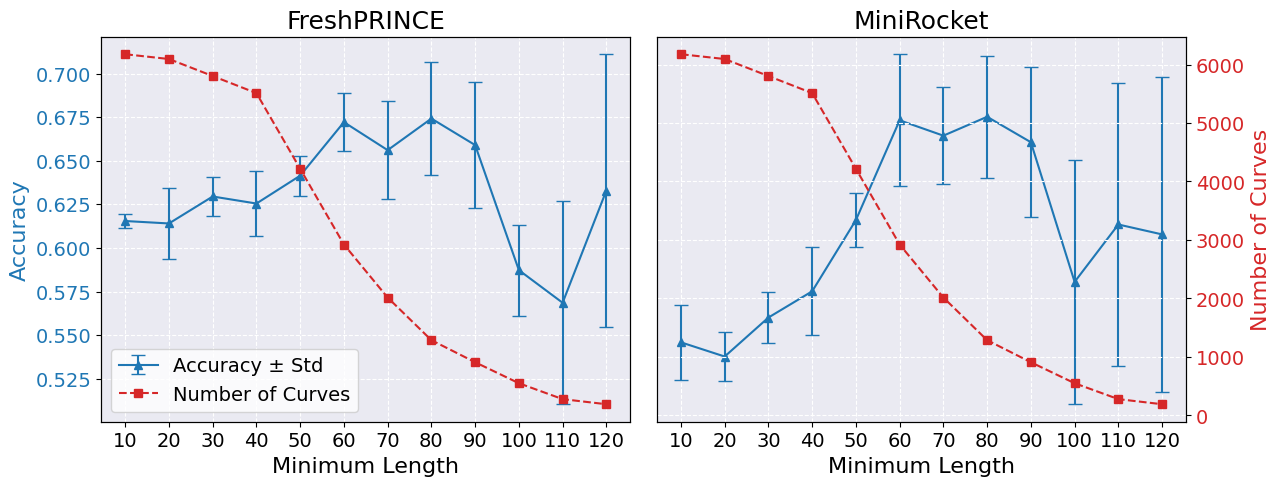

In [5]:
lengths = list(range(10, 130, 10))
minirocket_curve_counts = [6176, 6094, 5803, 5511, 4217, 2922, 2015, 1286, 909, 550, 278, 191]
num_curves = {
    10: 6176, 20: 6094, 30: 5803, 40: 5511, 50: 4217, 60: 2922,
    70: 2015, 80: 1286, 90: 909, 100: 550, 110: 278, 120: 191
}

minirocket_accuracies = {}
minirocket_stds = {}

for min_len in lengths:
    try:
        scores = joblib.load(f'scores/experiment-different-lengths/minirocket/minirocket_{min_len}_scores.joblib')
        minirocket_accuracies[min_len] = np.mean(scores)
        minirocket_stds[min_len] = np.std(scores)
    except Exception as e:
        print(f"MiniRocket: Skipping min_len={min_len} due to error: {e}")

valid_lengths_mini = [ml for ml in lengths if ml in minirocket_accuracies]
acc_mini = [minirocket_accuracies[ml] for ml in valid_lengths_mini]
std_mini = [minirocket_stds[ml] for ml in valid_lengths_mini]
curves_mini = [minirocket_curve_counts[lengths.index(ml)] for ml in valid_lengths_mini]

freshp_accuracies = {}
freshp_stds = {}

for min_len in lengths:
    try:
        scores = joblib.load(f'scores/experiment-different-lengths/freshprince/freshprince_{min_len}_scores.joblib')
        freshp_accuracies[min_len] = np.mean(scores)
        freshp_stds[min_len] = np.std(scores)
    except Exception as e:
        print(f"FreshP: Skipping min_len={min_len} due to error: {e}")

valid_lengths_freshp = [ml for ml in lengths if ml in freshp_accuracies]
acc_freshp = [freshp_accuracies[ml] for ml in valid_lengths_freshp]
std_freshp = [freshp_stds[ml] for ml in valid_lengths_freshp]
curves_freshp = [num_curves[ml] for ml in valid_lengths_freshp]

fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'wspace': 0.05})

# font sizes
title_fontsize = 18
label_fontsize = 16
tick_fontsize = 14
legend_fontsize = 14

# mini plot
ax1b = ax1.twinx()
ax1.errorbar(valid_lengths_mini, acc_mini, yerr=std_mini, fmt='-^', capsize=5, color='tab:blue', label='Accuracy ± Std')
ax1b.plot(valid_lengths_mini, curves_mini, 's--', color='tab:red', label='Number of Curves')

ax1.set_title("MiniRocket", fontsize=title_fontsize)
ax1.set_xlabel('Minimum Length', fontsize=label_fontsize)
ax1.set_xticks(lengths)
ax1.tick_params(axis='x', labelsize=tick_fontsize)
ax1.tick_params(axis='y', labelsize=tick_fontsize)
ax1.set_yticks([])
ax1.grid(True, linestyle='--', color='white')

ax1b.set_ylabel('Number of Curves', color='tab:red', fontsize=label_fontsize)
ax1b.tick_params(axis='y', labelcolor='tab:red', labelsize=tick_fontsize)
ax1b.grid(True, linestyle='--', color='white')

# freshp plot
ax2b = ax2.twinx()
ax2.errorbar(valid_lengths_freshp, acc_freshp, yerr=std_freshp, fmt='-^', capsize=5, color='tab:blue', label='Accuracy ± Std')
ax2b.plot(valid_lengths_freshp, curves_freshp, 's--', color='tab:red', label='Number of Curves')

ax2.set_title("FreshPRINCE", fontsize=title_fontsize)
ax2.set_xlabel('Minimum Length', fontsize=label_fontsize)
ax2.set_ylabel('Accuracy', color='tab:blue', fontsize=label_fontsize)
ax2.set_xticks(lengths)
ax2.tick_params(axis='x', labelsize=tick_fontsize)
ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=tick_fontsize)
ax2b.set_yticks([])  # Hide duplicate curve count ticks
ax2b.tick_params(axis='y', labelsize=tick_fontsize)

# legend
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2b.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='lower left', fontsize=legend_fontsize)
ax2.grid(True, linestyle='--', color='white')
ax2b.grid(True, linestyle='--', color='white')

# background color
ax1.set_facecolor('#EAEAF2')
ax1b.set_facecolor('#EAEAF2')
ax2.set_facecolor('#EAEAF2')
ax2b.set_facecolor('#EAEAF2')

plt.savefig("plots/separate_but_shared_axes.png")
plt.show()